In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import subprocess, psycopg2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime

plt.style.use('ggplot')

## Get the data from the Heroku PostgreSQL database

In [2]:
HEROKU_APP_NAME = "pxl-ss"
TABLE_NAME = "Temperature"

conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
connuri = conn_info.stdout.decode('utf-8').strip()

engine = create_engine(connuri)
raw_engine = engine.raw_connection()

data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)

## Restructure the data to form a time series

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 2 columns):
creation_date    231 non-null datetime64[ns]
value            231 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 3.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 231 entries, 2018-11-10 23:38:44.453789 to 2018-11-12 23:36:53.477224
Data columns (total 1 columns):
value    231 non-null float64
dtypes: float64(1)
memory usage: 3.6 KB
None


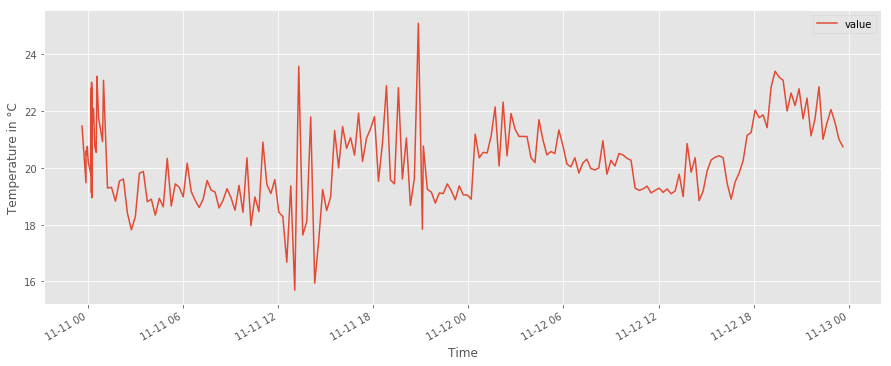

In [3]:
df = pd.DataFrame(data, columns = ['creation_date', 'value'])

# Inspect data
print(df.info())

# Convert the creation_date column to datetime64
df['creation_date'] = pd.to_datetime(df['creation_date'])
# Convert the value column to float
df['value'] = pd.to_numeric(df['value'])

# Set date_creation column as index
df.set_index('creation_date', inplace=True)

# Inspect data
print(df.info())

# Plot data
df.plot(figsize=(15, 6))
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()

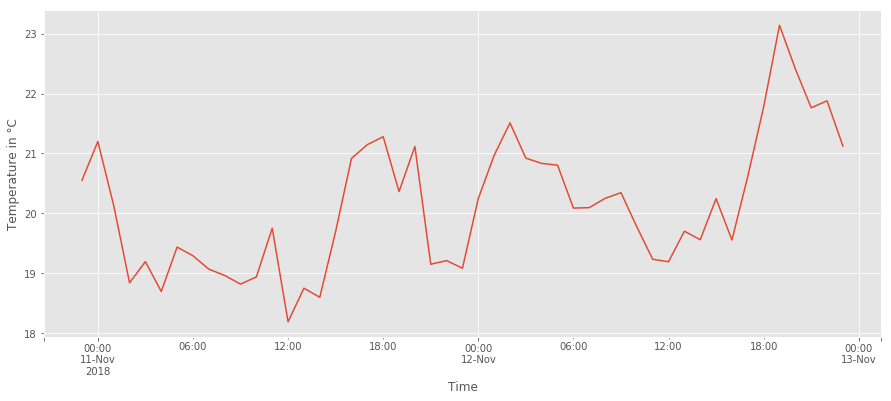

In [4]:
my_df = df['value'].resample('60T').mean()
my_df = my_df.fillna(my_df.bfill())
my_df.plot(figsize=(15, 6))
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()